In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model
from matplotlib import pyplot as plt
import pickle


Using TensorFlow backend.


In [2]:
cascade_path = '../model/cv2/haarcascade_frontalface_alt2.xml'

In [3]:
image_dir_basepath = '../data/images/'
names = ['LarryPage', 'MarkZuckerberg', 'BillGates','me','max','hollande1','hollande2']
image_size = 160

In [4]:
model_path = '../facenet_keras.h5'
model = load_model(model_path)

model.load_weights('../facenet_keras_weights.h5')

C:\Users\gouzm\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [161]:
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)

        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [207]:
def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict(aligned_images))
    embs = l2_normalize(np.concatenate(pd))
    print(aligned_images[start:start+batch_size].shape)
    return embs,aligned_images

In [208]:
def calc_dist(img_name0, img_name1):
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

def calc_dist_plot(img_name0, img_name1):
    print(calc_dist(img_name0, img_name1))
    plt.subplot(1, 2, 1)
    plt.imshow(imread(data[img_name0]['image_filepath']))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(data[img_name1]['image_filepath']))

In [209]:
data = {}
for name in names:
    print(name)
    image_dirpath = image_dir_basepath + name
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    embs = calc_embs(image_filepaths)[0]
    aligned_images = calc_embs(image_filepaths)[1]
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}

LarryPage


C:\Users\gouzm\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1, 160, 160, 3)
(1, 160, 160, 3)
MarkZuckerberg
(1, 160, 160, 3)
(1, 160, 160, 3)
BillGates
(1, 160, 160, 3)
(1, 160, 160, 3)
me
(1, 160, 160, 3)
(1, 160, 160, 3)
max
(1, 160, 160, 3)
(1, 160, 160, 3)
hollande1
(1, 160, 160, 3)
(1, 160, 160, 3)
hollande2
(1, 160, 160, 3)
(1, 160, 160, 3)


0.9962975978851318


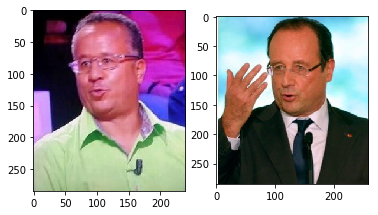

In [205]:
calc_dist_plot('hollande11', 'hollande21')

In [6]:
images_error = []

def scale(img_path,margin=10):
    aligned_images=[]
    cascade = cv2.CascadeClassifier(cascade_path)
    img = imread(img_path)
    faces = cascade.detectMultiScale(img,
                                     scaleFactor=1.1,
                                      minNeighbors=3)
    (x, y, w, h) = faces[0]
    cropped = img[y-margin//2:y+h+margin//2,
                    x-margin//2:x+w+margin//2, :]
    aligned = resize(cropped, (image_size, image_size), mode='reflect')
    aligned_images.append(aligned)
    return np.array(aligned_images)


def facenet(img_path, margin=10):
    try:
        aligned_images = prewhiten(scale(img_path,margin))
        #embs = model.predict(aligned_images)
        embs = model.predict(aligned_images)
        embs = l2_normalize(embs)
        return embs
    except:
        images_error.append(img_path)

C:\Users\gouzm\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


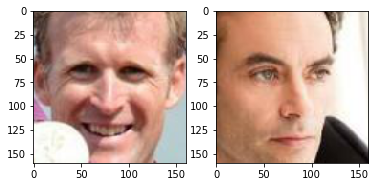

In [245]:
plt.subplot(1, 2, 1)
plt.imshow(scale('../img_align_celeba/000223.jpg')[0], interpolation='nearest')
plt.subplot(1, 2, 2)
plt.imshow(aligned, interpolation='nearest')

In [8]:
from tqdm import tqdm

path = '../img_align_celeba/'
features = {}

for subdir, dirs, files in os.walk(path):
    
    for file in tqdm(files):
        current = subdir+file
        features[current]=facenet(current)

  0%|                                                                                       | 0/108955 [00:00<?, ?it/s]C:\Users\gouzm\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
  0%|                                                                             | 9/108955 [00:02<9:27:06,  3.20it/s]


In [9]:
with open('features_facenet.pickle', 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('images_error.pickle', 'wb') as handle:
    pickle.dump(images_error, handle, protocol=pickle.HIGHEST_PROTOCOL)